# Dataset link: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection
# Glove file: https://nlp.stanford.edu/projects/glove/ 

In [1]:
#importing all required libraries

import pandas as pd
import numpy as np
import csv
from numpy.random import RandomState
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import string

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize 
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score,precision_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

np.random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\archa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\archa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#class to prepare the dataset required

class Dataset:
    def __init__(self, df = None):
        self.df = df
            
    def read_data(self, file):    
        self.df = pd.read_csv(file, sep ='\t',names=['label', 'text'])
        print("\nGiven UCI Dataset:\n\n", self.df.head)
        self.df = self.df.replace(['ham','spam'],[0, 1])
        self.plot_class()
        
    #plotting class distribution
    def plot_class(self): 
        print("\nClass distribution:\n", self.df['label'].value_counts())
        self.df['label'].value_counts().plot(kind = 'bar',color = ["green","red"])
        plt.title('Class distribution')
        plt.show()
       
    #performing preprocessing on text data
    def preprocess(self):
        #removing punctuations
        self.df["text1"] = self.df["text"].apply(lambda text: text.translate(str.maketrans('', '', string.punctuation)))
        
        #removing stop words
        STOPWORDS = set(stopwords.words('english'))
        self.df["text2"] = self.df["text1"].apply(lambda text1: " ".join([word for word in str(text1).split() if word not in STOPWORDS]))
        
        #performing stemming
        self.df["text3"] = self.df["text2"].apply(lambda text2: " ".join([PorterStemmer().stem(word) for word in text2.split()]))
        
        return self.df
    
    #splitting into train and test
    def split(self):
        X_train, X_test, y_train, y_test = train_test_split(self.df['text3'], self.df['label'], test_size = 0.3, random_state = 37)
        print ("X_train size: ", len(X_train))
        print("X_test size: ", len(X_test))
        print("y_train size: ", len(y_train))
        print("y_test size: ", len(y_test))
        return X_train, X_test, y_train, y_test
    

In [3]:
#class to define Traditional Machine Learning Classifiers from SKLearn

class Spam_Classification_ML:
    
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
    
    def prepare_models(self):
        models = {} 
        #LR
        models['Logistic_Regression'] = LogisticRegression(max_iter = 80, solver = 'newton-cg')
        #SVC
        models['SVC'] = SVC(gamma = 'auto')
        #MNB
        models['MultinomialNB'] = MultinomialNB(alpha = 0.5)
        #DT
        models['Decision_Tree'] = DecisionTreeClassifier(criterion = 'gini')
        #KNN
        models['KNN'] = KNeighborsClassifier(weights = 'distance')     
        #RF
        models['RandomForest'] = RandomForestClassifier(max_features = 'log2', criterion = 'gini')
        return models
    
    def evaluate(self, models):
        for model in models:
            y_pred = None
            print("\n\nRunning model: {}".format(model))
            current_model = models[model]
            
            #vectorizing the text data
            cv = CountVectorizer(max_features = 1500)
            cv.fit(self.X_train)
            X_train_cv = cv.transform(self.X_train)
            X_test_cv = cv.transform(self.X_test)
            
            current_model.fit(X_train_cv, self.y_train)
            y_pred = current_model.predict(X_test_cv)
            print(" Train accuracy is {:.2f}".format(current_model.score(X_train_cv, self.y_train) * 100))
            print(" Test accuracy is {:.2f}".format(accuracy_score(self.y_test, y_pred) * 100))
            print(" F1 Score: {:.2f}".format(f1_score(self.y_test, y_pred, average='macro') * 100))
            print(" Precision Score: {:.2f}".format(precision_score(self.y_test, y_pred, average='macro') * 100))
            print(" Recall Score: {:.2f}".format(recall_score(self.y_test, y_pred, average='macro') * 100))
            print(classification_report(self.y_test, y_pred))
            

In [4]:
#class to define Word Embedding Layers using GLOVE with Deep Learning

class Spam_Classification_DL:
    
    def __init__(self, df, X_train, X_test, y_train, y_test):
        self.df = df
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
    
    #creating embedding vector from the given glove.6B.100d.txt
    def glove(self):
        embedding_vector = {}
        f = open('glove.6B.100d.txt', encoding='utf-8')
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_vector[word] = coefs
        f.close()
        print('\nFound %s word vectors in glove.\n' % len(embedding_vector))
        self.matrix(embedding_vector)
        
    #tokenizing the text data
    def token(self):
        tok = Tokenizer()
        tok.fit_on_texts(self.df["text3"])
        return tok
    
    #creating embedding matrix
    def matrix(self, embedding_vector):
        tok = self.token()
        self.vocab_size = len(tok.word_index) + 1

        self.embedding_matrix = np.zeros((self.vocab_size, 100))
        for word, i in tok.word_index.items():
            embedding_value = embedding_vector.get(word)
            if embedding_value is not None:
                self.embedding_matrix[i] = embedding_value

        print("Embedding matrix shape\n",self.embedding_matrix.shape)      
    
    
    #sequencing : each sentence represented by sequences of numbers using texts_to_sequences from tokenizer object
    #padding : we padded the sequence so that we can have same length of each sequence
    #Sequencing and padding on training and testing 
    def prepare_train_test(self):
        tokenizer = Tokenizer(num_words = self.vocab_size, char_level=False, oov_token = "<OOV>")
        tokenizer.fit_on_texts(self.X_train)
        word_index = tokenizer.word_index
        tot_words = len(word_index)
        print('There are %s unique tokens in training data. \n' % tot_words)
        
        train_seq = tokenizer.texts_to_sequences(self.X_train)
        train_padded = pad_sequences(train_seq, maxlen = 50, 
                                         padding = "post", truncating = "post")

        test_seq = tokenizer.texts_to_sequences(self.X_test)
        test_padded = pad_sequences(test_seq, maxlen = 50,
                                      padding = "post", truncating = "post")
        return train_padded, test_padded
    
    #Dense model architecture with two dense layers
    def model(self):
        train_padded, test_padded = self.prepare_train_test()
        model = Sequential()
        #glove embedding layer
        model.add(Embedding(self.vocab_size, 100, weights = [self.embedding_matrix], input_length=50, trainable = False))
        
        model.add(GlobalAveragePooling1D())
        model.add(Dense(24, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        print(model.summary())
        
        model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=3)
        model.fit(train_padded, self.y_train, epochs=30, 
                  validation_data=(test_padded, self.y_test),callbacks =[early_stop], verbose=2)
        


PART1

SPAM classification using Traditional Machine Learning Classifiers from SKLearn



Given UCI Dataset:

 <bound method NDFrame.head of      label                                               text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]>

Class distribution:
 0    4825
1     747
Name: label, dtype: int64


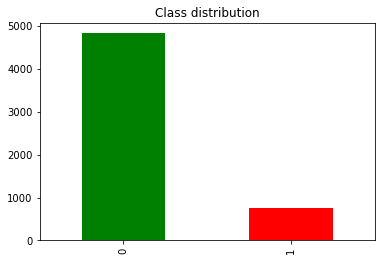

X_train size:  3900
X_test size:  1672
y_train size:  3900
y_test size:  1672


Running model: Logistic_Regression
 Train accuracy is 99.23
 Test accuracy is 98.09
 F1 Score: 95.95
 Precision Score: 97.92
 Recall Score: 94.20
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1432
           1       0.98      0.89      0.93       240

    accuracy                           0.98      1672
   macro avg       0.98      0.94      0.96      1672
weighted avg       0.98      0.98      0.98      1672



Running model: SVC
 Train accuracy is 87.00
 Test accuracy is 85.65
 F1 Score: 46.13
 Precision Score: 42.82
 Recall Score: 50.00
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1432
           1       0.00      0.00      0.00       240

    accuracy                           0.86      1672
   macro avg       0.43      0.50      0.46      1672
weighted avg       0.73      0.86      0.79

C:\Users\archa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\archa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\archa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\archa\anaconda3\lib\site-packages\sklearn\metrics\_classifi

 Train accuracy is 99.95
 Test accuracy is 95.45
 F1 Score: 90.79
 Precision Score: 90.65
 Recall Score: 90.93
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1432
           1       0.84      0.85      0.84       240

    accuracy                           0.95      1672
   macro avg       0.91      0.91      0.91      1672
weighted avg       0.95      0.95      0.95      1672



Running model: KNN
 Train accuracy is 99.95
 Test accuracy is 93.96
 F1 Score: 85.04
 Precision Score: 96.38
 Recall Score: 79.13
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1432
           1       0.99      0.58      0.73       240

    accuracy                           0.94      1672
   macro avg       0.96      0.79      0.85      1672
weighted avg       0.94      0.94      0.93      1672



Running model: RandomForest
 Train accuracy is 99.95
 Test accuracy is 97.49
 F1 Score: 94.48
 Precis

In [5]:
#Main point of execution

if __name__ == "__main__":
    file = 'SMSSpamCollection'
    print("\nPART1")
    print("\nSPAM classification using Traditional Machine Learning Classifiers from SKLearn\n\n")
    dataset = Dataset()
    dataset.read_data(file)
    df = dataset.preprocess()
    X_train, X_test, y_train, y_test = dataset.split()
    
    spam_class_ml = Spam_Classification_ML(X_train, X_test, y_train, y_test)
    models = spam_class_ml.prepare_models()
    spam_class_ml.evaluate(models)
    
    print("\n\nPART2")
    print("\nSPAM classification using Use GLOVE Word Embedding Layers with Deep Learning\n\n")
    spam_class_dl = Spam_Classification_DL(df, X_train, X_test, y_train, y_test)
    spam_class_dl.glove()
    spam_class_dl.model()
    